# Тензорные разложения как инструмент сжатия нейронных сетей

In [1]:
! pip install tensorly==0.7.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 198.1/198.1 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.7/154.7 kB 11.4 MB/s eta 0:00:00


In [2]:
! pip install --upgrade git+https://github.com/sovrasov/flops-counter.pytorch.git

  Cloning https://github.com/sovrasov/flops-counter.pytorch.git to /tmp/pip-req-build-mhf4rayb
  Running command git clone --filter=blob:none --quiet https://github.com/sovrasov/flops-counter.pytorch.git /tmp/pip-req-build-mhf4rayb
  Resolved https://github.com/sovrasov/flops-counter.pytorch.git to commit a05c2a8158f658d5876b4bdccd76eaedbe9e161d
  Preparing metadata (setup.py) ... done
  Created wheel for ptflops: filename=ptflops-0.7.2-py3-none-any.whl size=14692 sha256=1caa3ae4bc074be55ab127ee8561fa94c95f043a6693648c9a25a19f59e18e0c
  Stored in directory: /tmp/pip-ephem-wheel-cache-2wdh01x9/wheels/36/bd/4e/5345333341cf3e77a47777963004c9ce5b861f774ca55e2e96
Successfully built ptflops


In [3]:
import torch
import numpy as np
import torch.nn as nn
import tensorly as tl
import torch.optim as optim
import matplotlib.pyplot as plt
import torchvision.models as models

from tqdm.notebook import tqdm
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader
from scipy.optimize import minimize_scalar
from ptflops import get_model_complexity_info
from tensorly.decomposition import parafac, partial_tucker

In [4]:
plt.style.use("ggplot")
tl.set_backend("pytorch")

In [5]:
def get_cifar10_data(batch_size=64):
    dataset_train = datasets.CIFAR10(
        root="data",
        train=True,
        download=True,
        transform=transforms.Compose(
            [
                transforms.RandomCrop(32, padding=4),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
            ]
        ),
    )
    dataset_valid = datasets.CIFAR10(
        root="data",
        train=False,
        download=True,
        transform=transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
            ]
        ),
    )

    train_loader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
    valid_loader = DataLoader(dataset_valid, batch_size=batch_size, shuffle=False)

    return train_loader, valid_loader

In [6]:
def build_model(pretrained=True, fine_tune=True, num_classes=1):
    if pretrained:
        model = models.resnet18(weights=models.resnet18(weights=models.ResNet18_Weights.DEFAULT))
        print("[INFO]: Loading pre-trained weights")
    else:
        model = models.resnet18(weights=None)
        print("[INFO]: Not loading pre-trained weights")

    if fine_tune:
        print("[INFO]: Fine-tuning all layers...")
    else:
        print("[INFO]: Freezing hidden layers...")

    for params in model.parameters():
        params.requires_grad = fine_tune

    model.fc = nn.Linear(512, num_classes)

    return model

In [7]:
def train(model, trainloader, optimizer, criterion, device):
    print("Training...")

    model.train()

    counter = 0
    train_running_loss = 0
    train_running_correct = 0
    for i, data in tqdm(enumerate(trainloader), total=len(trainloader)):
        counter += 1

        image, labels = data
        image = image.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(image)

        loss = criterion(outputs, labels)
        train_running_loss += loss.item()

        _, preds = torch.max(outputs.data, 1)
        train_running_correct += (preds == labels).sum().item()

        loss.backward()

        optimizer.step()


    epoch_loss = train_running_loss / counter

    epoch_acc = 100 * (train_running_correct / len(trainloader.dataset))

    return epoch_loss, epoch_acc

In [8]:
def validate(model, testloader, criterion, device):
    print("Validation...")

    model.eval()

    counter = 0
    valid_running_loss = 0
    valid_running_correct = 0
    with torch.no_grad():
        for i, data in tqdm(enumerate(testloader), total=len(testloader)):
            counter += 1

            image, labels = data
            image = image.to(device)
            labels = labels.to(device)

            outputs = model(image)

            loss = criterion(outputs, labels)
            valid_running_loss += loss.item()

            _, preds = torch.max(outputs.data, 1)
            valid_running_correct += (preds == labels).sum().item()

    epoch_loss = valid_running_loss / counter
    epoch_acc = 100 * (valid_running_correct / len(testloader.dataset))

    return epoch_loss, epoch_acc

In [9]:
epochs = 20
batch_size = 64
learning_rate = 0.01
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [10]:
model = build_model(num_classes=10).to(device)

optimizer = optim.SGD(model.parameters(), lr=learning_rate)

criterion = nn.CrossEntropyLoss()

train_loader, valid_loader = get_cifar10_data(batch_size=batch_size)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 95.3MB/s]
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


[INFO]: Loading pre-trained weights
[INFO]: Fine-tuning all layers...


100%|██████████| 170498071/170498071 [00:03<00:00, 48117014.09it/s]


Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified


In [11]:
macs, params = get_model_complexity_info(
    model,
    (3, 32, 32),
    as_strings=True,
    print_per_layer_stat=True,
    verbose=True,
)
print(f"Computational complexity: {macs:<8}")
print(f"Number of parameters: {params:<8}")

ResNet(
  11.18 M, 100.000% Params, 37.18 MMac, 99.828% MACs, 
  (conv1): Conv2d(9.41 k, 0.084% Params, 2.41 MMac, 6.466% MACs, 3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(128, 0.001% Params, 32.77 KMac, 0.088% MACs, 64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(0, 0.000% Params, 16.38 KMac, 0.044% MACs, inplace=True)
  (maxpool): MaxPool2d(0, 0.000% Params, 16.38 KMac, 0.044% MACs, kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    147.97 k, 1.323% Params, 9.49 MMac, 25.469% MACs, 
    (0): BasicBlock(
      73.98 k, 0.662% Params, 4.74 MMac, 12.735% MACs, 
      (conv1): Conv2d(36.86 k, 0.330% Params, 2.36 MMac, 6.334% MACs, 64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, 0.001% Params, 8.19 KMac, 0.022% MACs, 64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(0, 0.000% Pa

In [12]:
total_params = sum(p.numel() for p in model.parameters())

print(f"{total_params:,} total parameters.")

total_trainable_params = sum(
    p.numel()
    for p in model.parameters()
    if p.requires_grad
)

print(f"{total_trainable_params:,} training parameters.")

11,181,642 total parameters.
11,181,642 training parameters.


In [13]:
train_loss, valid_loss = [], []
train_acc, valid_acc = [], []
for epoch in tqdm(range(epochs)):
    print(f"[INFO]: Epoch {epoch+1} of {epochs}")

    train_epoch_loss, train_epoch_acc = train(
        model,
        train_loader,
        optimizer,
        criterion,
        device,
    )
    valid_epoch_loss, valid_epoch_acc = validate(
        model,
        valid_loader,
        criterion,
        device,
    )

    train_loss.append(train_epoch_loss)
    valid_loss.append(valid_epoch_loss)
    train_acc.append(train_epoch_acc)
    valid_acc.append(valid_epoch_acc)

    print(f"Training loss: {train_epoch_loss:.3f}, training acc: {train_epoch_acc:.3f}")
    print(f"Validation loss: {valid_epoch_loss:.3f}, validation acc: {valid_epoch_acc:.3f}")
    print("-" * 50)

  0%|          | 0/20 [00:00<?, ?it/s]

[INFO]: Epoch 1 of 20
Training...


  0%|          | 0/782 [00:00<?, ?it/s]

Validation...


  0%|          | 0/157 [00:00<?, ?it/s]

Training loss: 1.168, training acc: 58.846
Validation loss: 0.844, validation acc: 71.070
--------------------------------------------------
[INFO]: Epoch 2 of 20
Training...


  0%|          | 0/782 [00:00<?, ?it/s]

Validation...


  0%|          | 0/157 [00:00<?, ?it/s]

Training loss: 0.823, training acc: 71.412
Validation loss: 0.747, validation acc: 74.060
--------------------------------------------------
[INFO]: Epoch 3 of 20
Training...


  0%|          | 0/782 [00:00<?, ?it/s]

Validation...


  0%|          | 0/157 [00:00<?, ?it/s]

Training loss: 0.712, training acc: 75.354
Validation loss: 0.658, validation acc: 77.300
--------------------------------------------------
[INFO]: Epoch 4 of 20
Training...


  0%|          | 0/782 [00:00<?, ?it/s]

Validation...


  0%|          | 0/157 [00:00<?, ?it/s]

Training loss: 0.643, training acc: 77.478
Validation loss: 0.642, validation acc: 77.840
--------------------------------------------------
[INFO]: Epoch 5 of 20
Training...


  0%|          | 0/782 [00:00<?, ?it/s]

Validation...


  0%|          | 0/157 [00:00<?, ?it/s]

Training loss: 0.598, training acc: 79.074
Validation loss: 0.650, validation acc: 77.890
--------------------------------------------------
[INFO]: Epoch 6 of 20
Training...


  0%|          | 0/782 [00:00<?, ?it/s]

Validation...


  0%|          | 0/157 [00:00<?, ?it/s]

Training loss: 0.559, training acc: 80.408
Validation loss: 0.567, validation acc: 80.520
--------------------------------------------------
[INFO]: Epoch 7 of 20
Training...


  0%|          | 0/782 [00:00<?, ?it/s]

Validation...


  0%|          | 0/157 [00:00<?, ?it/s]

Training loss: 0.527, training acc: 81.544
Validation loss: 0.572, validation acc: 80.810
--------------------------------------------------
[INFO]: Epoch 8 of 20
Training...


  0%|          | 0/782 [00:00<?, ?it/s]

Validation...


  0%|          | 0/157 [00:00<?, ?it/s]

Training loss: 0.500, training acc: 82.514
Validation loss: 0.577, validation acc: 80.820
--------------------------------------------------
[INFO]: Epoch 9 of 20
Training...


  0%|          | 0/782 [00:00<?, ?it/s]

Validation...


  0%|          | 0/157 [00:00<?, ?it/s]

Training loss: 0.470, training acc: 83.588
Validation loss: 0.628, validation acc: 79.420
--------------------------------------------------
[INFO]: Epoch 10 of 20
Training...


  0%|          | 0/782 [00:00<?, ?it/s]

Validation...


  0%|          | 0/157 [00:00<?, ?it/s]

Training loss: 0.456, training acc: 84.060
Validation loss: 0.526, validation acc: 82.190
--------------------------------------------------
[INFO]: Epoch 11 of 20
Training...


  0%|          | 0/782 [00:00<?, ?it/s]

Validation...


  0%|          | 0/157 [00:00<?, ?it/s]

Training loss: 0.438, training acc: 84.732
Validation loss: 0.511, validation acc: 82.910
--------------------------------------------------
[INFO]: Epoch 12 of 20
Training...


  0%|          | 0/782 [00:00<?, ?it/s]

Validation...


  0%|          | 0/157 [00:00<?, ?it/s]

Training loss: 0.411, training acc: 85.492
Validation loss: 0.520, validation acc: 82.850
--------------------------------------------------
[INFO]: Epoch 13 of 20
Training...


  0%|          | 0/782 [00:00<?, ?it/s]

Validation...


  0%|          | 0/157 [00:00<?, ?it/s]

Training loss: 0.406, training acc: 85.896
Validation loss: 0.530, validation acc: 82.910
--------------------------------------------------
[INFO]: Epoch 14 of 20
Training...


  0%|          | 0/782 [00:00<?, ?it/s]

Validation...


  0%|          | 0/157 [00:00<?, ?it/s]

Training loss: 0.382, training acc: 86.398
Validation loss: 0.485, validation acc: 84.090
--------------------------------------------------
[INFO]: Epoch 15 of 20
Training...


  0%|          | 0/782 [00:00<?, ?it/s]

Validation...


  0%|          | 0/157 [00:00<?, ?it/s]

Training loss: 0.367, training acc: 86.972
Validation loss: 0.498, validation acc: 83.630
--------------------------------------------------
[INFO]: Epoch 16 of 20
Training...


  0%|          | 0/782 [00:00<?, ?it/s]

Validation...


  0%|          | 0/157 [00:00<?, ?it/s]

Training loss: 0.354, training acc: 87.442
Validation loss: 0.540, validation acc: 82.950
--------------------------------------------------
[INFO]: Epoch 17 of 20
Training...


  0%|          | 0/782 [00:00<?, ?it/s]

Validation...


  0%|          | 0/157 [00:00<?, ?it/s]

Training loss: 0.345, training acc: 87.748
Validation loss: 0.504, validation acc: 84.220
--------------------------------------------------
[INFO]: Epoch 18 of 20
Training...


  0%|          | 0/782 [00:00<?, ?it/s]

Validation...


  0%|          | 0/157 [00:00<?, ?it/s]

Training loss: 0.332, training acc: 88.224
Validation loss: 0.503, validation acc: 83.870
--------------------------------------------------
[INFO]: Epoch 19 of 20
Training...


  0%|          | 0/782 [00:00<?, ?it/s]

Validation...


  0%|          | 0/157 [00:00<?, ?it/s]

Training loss: 0.323, training acc: 88.418
Validation loss: 0.510, validation acc: 83.940
--------------------------------------------------
[INFO]: Epoch 20 of 20
Training...


  0%|          | 0/782 [00:00<?, ?it/s]

Validation...


  0%|          | 0/157 [00:00<?, ?it/s]

Training loss: 0.307, training acc: 89.212
Validation loss: 0.513, validation acc: 84.030
--------------------------------------------------


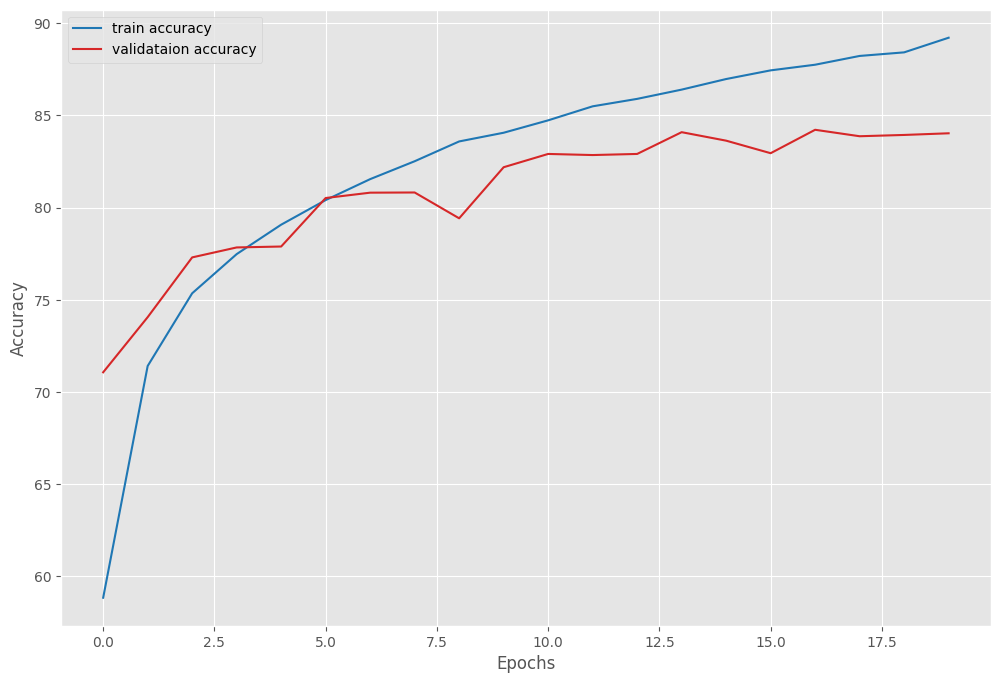

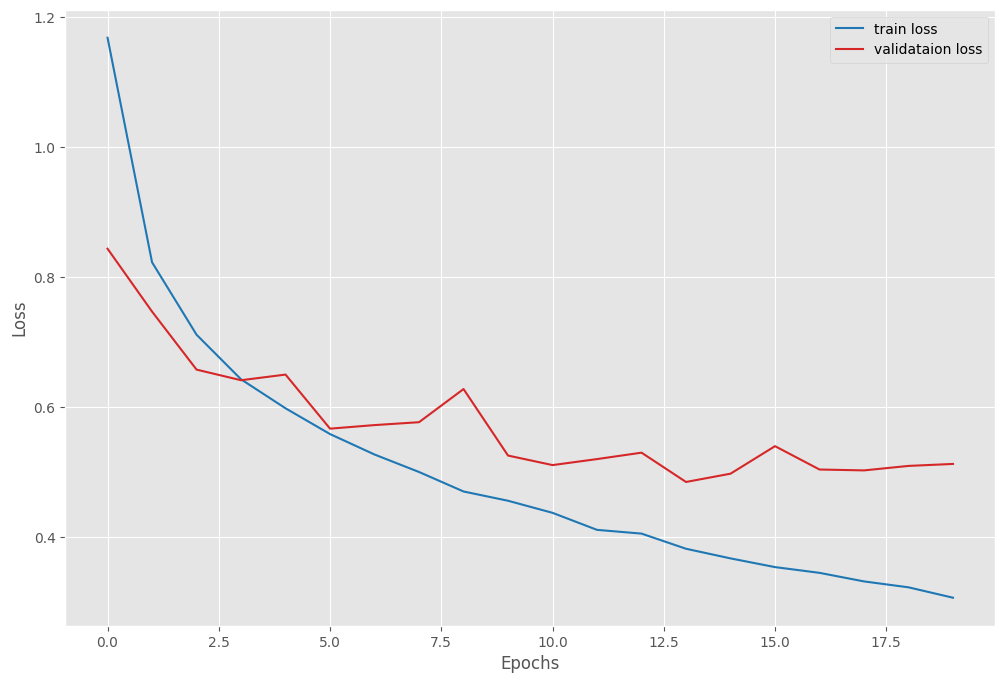

In [14]:
plt.figure(figsize=(12, 8))
plt.plot(train_acc, color="tab:blue", linestyle="-", label="train accuracy")
plt.plot(valid_acc, color="tab:red", linestyle="-", label="validataion accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

plt.figure(figsize=(12, 8))
plt.plot(train_loss, color="tab:blue", linestyle="-", label="train loss")
plt.plot(valid_loss, color="tab:red", linestyle="-", label="validataion loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

# decompositions

In [15]:
def evb_sigma2(sigma2, L, M, s, residual, xubar):
    H = len(s)

    alpha = L / M
    x = s**2 / (M * sigma2)

    z1 = x[x > xubar]
    tau_z1 = 0.5 * (z1 - (1 + alpha) + np.sqrt((z1 - (1 + alpha)) ** 2 - 4 * alpha))

    z2 = x[x <= xubar]

    term1 = np.sum(z2 - np.log(z2))
    term2 = np.sum(z1 - tau_z1)
    term3 = np.sum(np.log(np.divide(tau_z1 + 1, z1)))
    term4 = alpha * np.sum(np.log(tau_z1 / alpha + 1))

    return (term1 + term2 + term3 + term4 + residual / (M * sigma2) + (L - H) * np.log(sigma2))

In [16]:
def evbmf_short(Y, sigma2=None, H=None):
    L, M = Y.shape

    if H is None:
        H = L

    alpha = L / M
    tauubar = 2.5129 * np.sqrt(alpha)

    U, s, V = np.linalg.svd(Y)
    U = U[:, :H]
    s = s[:H]
    V = V[:H].T

    residual = 0.0
    if H < L:
        residual = np.sum(np.sum(Y**2) - np.sum(s**2))

    if sigma2 is None:
        xubar = (1 + tauubar) * (1 + alpha / tauubar)
        eH_ub = int(np.min([np.ceil(L / (1 + alpha)) - 1, H])) - 1
        upper_bound = (np.sum(s**2) + residual) / (L * M)
        lower_bound = np.max(
            [s[eH_ub + 1] ** 2 / (M * xubar), np.mean(s[eH_ub + 1 :] ** 2) / M]
        )

        scale = 1.0
        s = s * np.sqrt(scale)
        residual = residual * scale
        lower_bound = lower_bound * scale
        upper_bound = upper_bound * scale

        sigma2_opt = minimize_scalar(
            evb_sigma2,
            args=(L, M, s, residual, xubar),
            bounds=[lower_bound, upper_bound],
            method="Bounded",
        )
        sigma2 = sigma2_opt.x

    threshold = np.sqrt(M * sigma2 * (1 + tauubar) * (1 + alpha / tauubar))
    pos = np.sum(s > threshold)

    d = np.multiply(
        s[:pos] / 2,
        1 - np.divide((L + M) * sigma2, s[:pos] ** 2)
        + np.sqrt(
            (1 - np.divide((L + M) * sigma2, s[:pos] ** 2)) ** 2
            - 4 * L * M * sigma2**2 / s[:pos] ** 4
        ),
    )

    return np.diag(d)

In [17]:
def get_ranks(layer):
    weights = layer.weight.data

    unfold_0 = tl.base.unfold(weights, 0)
    unfold_1 = tl.base.unfold(weights, 1)

    diag_0 = evbmf_short(unfold_0)
    diag_1 = evbmf_short(unfold_1)

    return [diag_0.shape[0], diag_1.shape[1]]

In [18]:
def canonical_polyadic_decomposition(layer, ranks=None):
    if ranks is None:
        ranks = get_ranks(layer)
    rank = ranks[0] if ranks[0] != 0 else ranks[1]

    last, first, vertical, horizontal = parafac(layer.weight.data, rank=rank, init="random").factors

    pointwise_s_to_r_layer = nn.Conv2d(
        in_channels=first.shape[0],
        out_channels=first.shape[1],
        kernel_size=1,
        padding=0,
        bias=False,
    )

    depthwise_r_to_r_layer = nn.Conv2d(
        in_channels=rank,
        out_channels=rank,
        kernel_size=vertical.shape[0],
        stride=layer.stride,
        padding=layer.padding,
        dilation=layer.dilation,
        groups=rank,
        bias=False,
    )

    pointwise_r_to_t_layer = nn.Conv2d(
        in_channels=last.shape[1],
        out_channels=last.shape[0],
        kernel_size=1,
        padding=0,
        bias=True,
    )

    if layer.bias is not None:
        pointwise_r_to_t_layer.bias.data = layer.bias.data

    pointwise_s_to_r_layer.weight.data = first.t_().unsqueeze_(-1).unsqueeze_(-1)
    pointwise_r_to_t_layer.weight.data = last.unsqueeze_(-1).unsqueeze_(-1)
    depthwise_r_to_r_layer.weight.data = torch.stack(
        [
            vertical.narrow(1, i, 1) @ torch.t(horizontal).narrow(0, i, 1)
            for i in range(rank)
        ]
    ).unsqueeze_(1)


    return nn.Sequential(
        *[
            pointwise_s_to_r_layer,
            depthwise_r_to_r_layer,
            pointwise_r_to_t_layer,
        ]
    )

In [19]:
def tucker_decomposition(layer, ranks=None):
    if ranks is None:
        ranks = get_ranks(layer)

    if 0 in ranks:
        ranks.remove(0)
        ranks = [ranks[0], ranks[0]]

    core, [last, first] = partial_tucker(layer.weight.data, modes=[0, 1], rank=ranks, init="svd")

    first_layer = torch.nn.Conv2d(
        in_channels=first.shape[0],
        out_channels=first.shape[1],
        kernel_size=1,
        stride=1,
        padding=0,
        dilation=layer.dilation,
        bias=False,
    )

    core_layer = torch.nn.Conv2d(
        in_channels=core.shape[1],
        out_channels=core.shape[0],
        kernel_size=layer.kernel_size,
        stride=layer.stride,
        padding=layer.padding,
        dilation=layer.dilation,
        bias=False,
    )

    last_layer = torch.nn.Conv2d(
        in_channels=last.shape[1],
        out_channels=last.shape[0],
        kernel_size=1,
        stride=1,
        padding=0,
        dilation=layer.dilation,
        bias=True,
    )

    if layer.bias is not None:
        last_layer.bias.data = layer.bias.data

    first_layer.weight.data = torch.transpose(first, 1, 0).unsqueeze(-1).unsqueeze(-1)
    last_layer.weight.data = last.unsqueeze(-1).unsqueeze(-1)
    core_layer.weight.data = core

    return nn.Sequential(
        *[
            first_layer,
            core_layer,
            last_layer,
        ]
    )

## cpd

In [21]:
import copy

In [28]:
model_v2 = copy.deepcopy(model).cpu()

In [29]:
for name, metadata in model_v2.named_children():
    num_children = sum(1 for i in metadata.children())

    if num_children != 0:
        layer = getattr(model_v2, name)

        for i in range(num_children):
            last_block = layer[i]
            conv2 = getattr(last_block, "conv2")

            ranks = [conv2.weight.size(0)//2, conv2.weight.size(1)//2]
            print(ranks)
            new_layer = canonical_polyadic_decomposition(conv2, ranks)

            setattr(last_block, "conv2", new_layer)

[32, 32]
[32, 32]
[64, 64]
[64, 64]
[128, 128]
[128, 128]
[256, 256]
[256, 256]


In [30]:
macs_v2, params_v2 = get_model_complexity_info(
    model_v2,
    (3, 32, 32),
    as_strings=True,
    print_per_layer_stat=True,
    verbose=True,
)
print(f"Computational complexity: {macs_v2:<8}")
print(f"Number of parameters: {params_v2:<8}")

ResNet(
  5.62 M, 100.000% Params, 20.49 MMac, 99.689% MACs, 
  (conv1): Conv2d(9.41 k, 0.167% Params, 2.41 MMac, 11.718% MACs, 3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(128, 0.002% Params, 32.77 KMac, 0.159% MACs, 64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(0, 0.000% Params, 16.38 KMac, 0.080% MACs, inplace=True)
  (maxpool): MaxPool2d(0, 0.000% Params, 16.38 KMac, 0.080% MACs, kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    83.14 k, 1.479% Params, 5.34 MMac, 25.967% MACs, 
    (0): BasicBlock(
      41.57 k, 0.739% Params, 2.67 MMac, 12.984% MACs, 
      (conv1): Conv2d(36.86 k, 0.656% Params, 2.36 MMac, 11.479% MACs, 64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, 0.002% Params, 8.19 KMac, 0.040% MACs, 64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(0, 0.000% Pa

In [31]:
model_v2 = model_v2.to(device)

In [32]:
valid_epoch_loss_v2, valid_epoch_acc_v2 = validate(
    model_v2,
    valid_loader,
    criterion,
    device,
)
print(f"Validation loss: {valid_epoch_loss_v2:.3f}, validation acc: {valid_epoch_acc_v2:.3f}")


Validation...


  0%|          | 0/157 [00:00<?, ?it/s]

Validation loss: 2.576, validation acc: 17.840


In [33]:
train_loss_v2, valid_loss_v2 = [], []
train_acc_v2, valid_acc_v2 = [], []
for epoch in tqdm(range(5)):
    print(f"[INFO]: Epoch {epoch+1} of {5}")

    train_epoch_loss_v2, train_epoch_acc_v2 = train(
        model_v2,
        train_loader,
        optimizer,
        criterion,
        device,
    )
    valid_epoch_loss_v2, valid_epoch_acc_v2 = validate(
        model_v2,
        valid_loader,
        criterion,
        device,
    )

    train_loss_v2.append(train_epoch_loss_v2)
    valid_loss_v2.append(valid_epoch_loss_v2)
    train_acc_v2.append(train_epoch_acc_v2)
    valid_acc_v2.append(valid_epoch_acc_v2)

    print(f"Training loss: {train_epoch_loss_v2:.3f}, training acc: {train_epoch_acc_v2:.3f}")
    print(f"Validation loss: {valid_epoch_loss_v2:.3f}, validation acc: {valid_epoch_acc_v2:.3f}")
    print("-" * 50)

  0%|          | 0/5 [00:00<?, ?it/s]

[INFO]: Epoch 1 of 5
Training...


  0%|          | 0/782 [00:00<?, ?it/s]

Validation...


  0%|          | 0/157 [00:00<?, ?it/s]

Training loss: 0.859, training acc: 69.714
Validation loss: 0.954, validation acc: 67.060
--------------------------------------------------
[INFO]: Epoch 2 of 5
Training...


  0%|          | 0/782 [00:00<?, ?it/s]

Validation...


  0%|          | 0/157 [00:00<?, ?it/s]

Training loss: 0.853, training acc: 70.082
Validation loss: 0.919, validation acc: 68.390
--------------------------------------------------
[INFO]: Epoch 3 of 5
Training...


  0%|          | 0/782 [00:00<?, ?it/s]

Validation...


  0%|          | 0/157 [00:00<?, ?it/s]

Training loss: 0.860, training acc: 69.678
Validation loss: 0.935, validation acc: 68.170
--------------------------------------------------
[INFO]: Epoch 4 of 5
Training...


  0%|          | 0/782 [00:00<?, ?it/s]

Validation...


  0%|          | 0/157 [00:00<?, ?it/s]

Training loss: 0.861, training acc: 69.698
Validation loss: 0.923, validation acc: 68.400
--------------------------------------------------
[INFO]: Epoch 5 of 5
Training...


  0%|          | 0/782 [00:00<?, ?it/s]

Validation...


  0%|          | 0/157 [00:00<?, ?it/s]

Training loss: 0.858, training acc: 69.638
Validation loss: 0.928, validation acc: 68.130
--------------------------------------------------


# tkd

In [22]:
model_v3 = copy.deepcopy(model).cpu()

In [23]:
for name, metadata in model_v3.named_children():
    num_children = sum(1 for i in metadata.children())

    if num_children != 0:
        layer = getattr(model_v3, name)

        for i in range(num_children):
            last_block = layer[i]
            conv2 = getattr(last_block, "conv2")

            ranks = [conv2.weight.size(0)//2, conv2.weight.size(1)//2]
            print(ranks)
            new_layer = tucker_decomposition(conv2)

            setattr(last_block, "conv2", new_layer)

[32, 32]
[32, 32]


/usr/local/lib/python3.10/dist-packages/tensorly/backend/core.py:1106: UserWarning: In partial_svd: converting to NumPy. Check SVD_FUNS for available alternatives if you want to avoid this.
  warnings.warn('In partial_svd: converting to NumPy.'


[64, 64]
[64, 64]
[128, 128]
[128, 128]
[256, 256]
[256, 256]


In [24]:
macs_v3, params_v3 = get_model_complexity_info(
    model_v3,
    (3, 32, 32),
    as_strings=True,
    print_per_layer_stat=True,
    verbose=True,
)
print(f"Computational complexity: {macs_v3:<8}")
print(f"Number of parameters: {params_v3:<8}")

ResNet(
  6.33 M, 100.000% Params, 21.61 MMac, 99.705% MACs, 
  (conv1): Conv2d(9.41 k, 0.149% Params, 2.41 MMac, 11.111% MACs, 3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(128, 0.002% Params, 32.77 KMac, 0.151% MACs, 64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(0, 0.000% Params, 16.38 KMac, 0.076% MACs, inplace=True)
  (maxpool): MaxPool2d(0, 0.000% Params, 16.38 KMac, 0.076% MACs, kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    87.53 k, 1.382% Params, 5.62 MMac, 25.917% MACs, 
    (0): BasicBlock(
      45.16 k, 0.713% Params, 2.9 MMac, 13.371% MACs, 
      (conv1): Conv2d(36.86 k, 0.582% Params, 2.36 MMac, 10.884% MACs, 64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, 0.002% Params, 8.19 KMac, 0.038% MACs, 64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(0, 0.000% Par

In [25]:
model_v3 = model_v3.to(device)

In [26]:
valid_epoch_loss_v3, valid_epoch_acc_v3 = validate(
    model_v3,
    valid_loader,
    criterion,
    device,
)

print(f"Validation loss: {valid_epoch_loss_v3:.3f}, validation acc: {valid_epoch_acc_v3:.3f}")
print("-" * 50)

Validation...


  0%|          | 0/157 [00:00<?, ?it/s]

Validation loss: 2.512, validation acc: 22.130
--------------------------------------------------


In [27]:
train_loss_v3, valid_loss_v3 = [], []
train_acc_v3, valid_acc_v3 = [], []
for epoch in tqdm(range(5)):
    print(f"[INFO]: Epoch {epoch+1} of {5}")

    train_epoch_loss_v3, train_epoch_acc_v3 = train(
        model_v3,
        train_loader,
        optimizer,
        criterion,
        device,
    )
    valid_epoch_loss_v3, valid_epoch_acc_v3 = validate(
        model_v3,
        valid_loader,
        criterion,
        device,
    )

    train_loss_v3.append(train_epoch_loss_v3)
    valid_loss_v3.append(valid_epoch_loss_v3)
    train_acc_v3.append(train_epoch_acc_v3)
    valid_acc_v3.append(valid_epoch_acc_v3)

    print(f"Training loss: {train_epoch_loss_v3:.3f}, training acc: {train_epoch_acc_v3:.3f}")
    print(f"Validation loss: {valid_epoch_loss_v3:.3f}, validation acc: {valid_epoch_acc_v3:.3f}")
    print("-" * 50)

  0%|          | 0/5 [00:00<?, ?it/s]

[INFO]: Epoch 1 of 20
Training...


  0%|          | 0/782 [00:00<?, ?it/s]

Validation...


  0%|          | 0/157 [00:00<?, ?it/s]

Training loss: 1.162, training acc: 65.614
Validation loss: 1.188, validation acc: 65.910
--------------------------------------------------
[INFO]: Epoch 2 of 20
Training...


  0%|          | 0/782 [00:00<?, ?it/s]

Validation...


  0%|          | 0/157 [00:00<?, ?it/s]

Training loss: 1.163, training acc: 65.766
Validation loss: 1.212, validation acc: 66.150
--------------------------------------------------
[INFO]: Epoch 3 of 20
Training...


  0%|          | 0/782 [00:00<?, ?it/s]

Validation...


  0%|          | 0/157 [00:00<?, ?it/s]

Training loss: 1.167, training acc: 65.640
Validation loss: 1.179, validation acc: 66.270
--------------------------------------------------
[INFO]: Epoch 4 of 20
Training...


  0%|          | 0/782 [00:00<?, ?it/s]

Validation...


  0%|          | 0/157 [00:00<?, ?it/s]

Training loss: 1.170, training acc: 65.718
Validation loss: 1.217, validation acc: 65.840
--------------------------------------------------
[INFO]: Epoch 5 of 20
Training...


  0%|          | 0/782 [00:00<?, ?it/s]

Validation...


  0%|          | 0/157 [00:00<?, ?it/s]

Training loss: 1.158, training acc: 65.778
Validation loss: 1.197, validation acc: 65.790
--------------------------------------------------
